# Spatial relationships and operations

In [1]:
%matplotlib inline

import pandas as pd
import geopandas

pd.options.display.max_rows = 10

In [2]:
countries = geopandas.read_file("zip://./data/ne_110m_admin_0_countries.zip")
cities = geopandas.read_file("zip://./data/ne_110m_populated_places.zip")
rivers = geopandas.read_file("zip://./data/ne_50m_rivers_lake_centerlines.zip")

## Spatial relationships

An important aspect of geospatial data is that we can look at *spatial relationships*: how two spatial objects relate to each other (whether they overlap, intersect, contain, .. one another).

The topological, set-theoretic relationships in GIS are typically based on the DE-9IM model. See https://en.wikipedia.org/wiki/Spatial_relation for more information.

![](img/TopologicSpatialRelations2.png)
(Image by [Krauss, CC BY-SA 3.0](https://en.wikipedia.org/wiki/Spatial_relation#/media/File:TopologicSpatialRelarions2.png))

### Relationships between individual objects

Let's first create some small toy spatial objects:

A polygon <small>(note: we use `.squeeze()` here to to extract the scalar geometry object from the GeoSeries of length 1)</small>:

In [6]:
belgium = countries.loc[countries['name'] == 'Belgium', 'geometry'].squeeze()

Two points:

In [7]:
paris = cities.loc[cities['name'] == 'Paris', 'geometry'].squeeze()
brussels = cities.loc[cities['name'] == 'Brussels', 'geometry'].squeeze()

And a linestring:

In [8]:
from shapely.geometry import LineString
line = LineString([paris, brussels])

Let's visualize those 4 geometry objects together (I only put them in a GeoSeries to easily display them together with the geopandas `.plot()` method):

<AxesSubplot:>

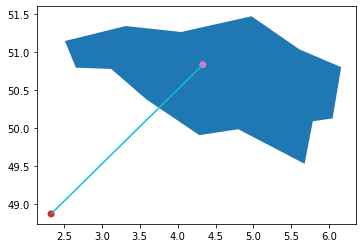

In [9]:
geopandas.GeoSeries([belgium, paris, brussels, line]).plot(cmap='tab10')

You can recognize the abstract shape of Belgium.

Brussels, the capital of Belgium, is thus located within Belgium. This is a spatial relationship, and we can test this using the individual shapely geometry objects as follow:

<AxesSubplot:>

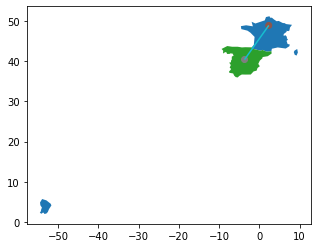

In [11]:
france = countries.loc[countries['name'] == 'France', 'geometry'].squeeze()
spain = countries.loc[countries['name'] == 'Spain', 'geometry'].squeeze()
madrid = cities.loc[cities['name'] == 'Madrid', 'geometry'].squeeze()
geopandas.GeoSeries([france, spain, paris, madrid, LineString([paris, madrid])]).plot(cmap='tab10')

In [12]:
brussels.within(belgium)

True

And using the reverse, Belgium contains Brussels:

In [13]:
belgium.contains(brussels)

True

On the other hand, Paris is not located in Belgium:

In [14]:
belgium.contains(paris)

False

In [15]:
paris.within(belgium)

False

The straight line we draw from Paris to Brussels is not fully located within Belgium, but it does intersect with it:

In [16]:
belgium.contains(line)

False

In [17]:
line.intersects(belgium)

True

### Spatial relationships with GeoDataFrames

The same methods that are available on individual `shapely` geometries as we have seen above, are also available as methods on `GeoSeries` / `GeoDataFrame` objects.

For example, if we call the `contains` method on the world dataset with the `paris` point, it will do this spatial check for each country in the `world` dataframe:

In [18]:
countries.contains(paris)

0      False
1      False
2      False
3      False
4      False
       ...  
172    False
173    False
174    False
175    False
176    False
Length: 177, dtype: bool

Because the above gives us a boolean result, we can use that to filter the dataframe:

In [19]:
countries[countries.contains(paris)]

,iso_a3,name,continent,pop_est,gdp_md_est,geometry
55,FRA,France,Europe,67106161.0,2699000.0,"MULTIPOLYGON (((2.51357 51.14851, 2.65842 50.7..."


And indeed, France is the only country in the world in which Paris is located.

Another example, extracting the linestring of the Amazon river in South America, we can query through which countries the river flows:

In [20]:
amazon = rivers[rivers['name'] == 'Amazonas'].geometry.squeeze()

In [21]:
countries[countries.crosses(amazon)]  # or .intersects

,iso_a3,name,continent,pop_est,gdp_md_est,geometry
22,BRA,Brazil,South America,207353391.0,3081000.0,"POLYGON ((-57.62513 -30.21629, -56.29090 -28.8..."
35,COL,Colombia,South America,47698524.0,688000.0,"POLYGON ((-66.87633 1.25336, -67.06505 1.13011..."
124,PER,Peru,South America,31036656.0,410400.0,"POLYGON ((-69.52968 -10.95173, -68.66508 -12.5..."


<div class="alert alert-info" style="font-size:120%">
<b>REFERENCE</b>: <br><br>

Overview of the different functions to check spatial relationships (*spatial predicate functions*):

<ul>
  <li>`equals`</li>
  <li>`contains`</li>
  <li>`crosses`</li>
  <li>`disjoint`</li>
  <li>`intersects`</li>
  <li>`overlaps`</li>
  <li>`touches`</li>
  <li>`within`</li>
  <li>`covers`</li>
</ul>

<p>
See https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships for an overview of those methods.
<p></p>
See https://en.wikipedia.org/wiki/DE-9IM for all details on the semantics of those operations.
</p>
</div>

In [23]:
# Countries that touch Brazil
brazil = countries.loc[countries['name'] == 'Brazil', 'geometry'].squeeze()
countries[countries.touches(brazil)]

,iso_a3,name,continent,pop_est,gdp_md_est,geometry
4,ARG,Argentina,South America,44293293.0,879400.0,"MULTIPOLYGON (((-66.95992 -54.89681, -67.56244..."
21,BOL,Bolivia,South America,11138234.0,78350.0,"POLYGON ((-62.68506 -22.24903, -62.84647 -22.0..."
35,COL,Colombia,South America,47698524.0,688000.0,"POLYGON ((-66.87633 1.25336, -67.06505 1.13011..."
55,FRA,France,Europe,67106161.0,2699000.0,"MULTIPOLYGON (((2.51357 51.14851, 2.65842 50.7..."
67,GUY,Guyana,South America,737718.0,6093.0,"POLYGON ((-56.53939 1.89952, -56.78270 1.86371..."
124,PER,Peru,South America,31036656.0,410400.0,"POLYGON ((-69.52968 -10.95173, -68.66508 -12.5..."
131,PRY,Paraguay,South America,6943739.0,64670.0,"POLYGON ((-54.62529 -25.73926, -54.78879 -26.6..."
148,SUR,Suriname,South America,591919.0,8547.0,"POLYGON ((-54.52475 2.31185, -55.09759 2.52375..."
167,URY,Uruguay,South America,3360148.0,73250.0,"POLYGON ((-58.42707 -33.90945, -58.34961 -33.2..."
170,VEN,Venezuela,South America,31304016.0,468600.0,"POLYGON ((-60.73357 5.20028, -60.60118 4.91810..."


## Spatial operations

Next to the spatial predicates that return boolean values, Shapely and GeoPandas aslo provide analysis methods that return new geometric objects.

See https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods for more details.

For example, using the toy data from above, let's construct a buffer around Brussels (which returns a Polygon):

<AxesSubplot:>

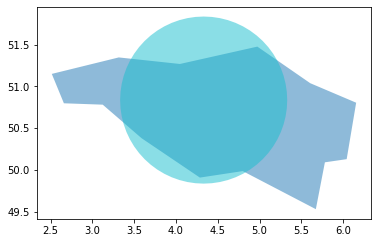

In [29]:
geopandas.GeoSeries([belgium, brussels.buffer(1)]).plot(alpha=0.5, cmap='tab10')

and now take the intersection, union or difference of those two polygons:

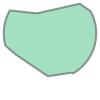

In [30]:
brussels.buffer(1).intersection(belgium)

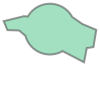

In [31]:
brussels.buffer(1).union(belgium)

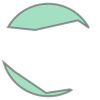

In [32]:
brussels.buffer(1).difference(belgium)

Another useful method is the `unary_union` attribute, which converts the set of geometry objects in a GeoDataFrame into a single geometry object by taking the union of all those geometries.

For example, we can construct a single object for the Africa continent:

<AxesSubplot:>

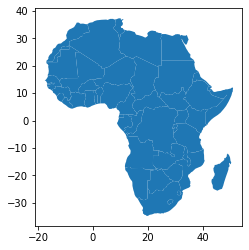

In [37]:
africa_countries = countries[countries['continent'] == 'Africa']
africa_countries.plot()

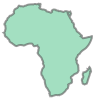

In [38]:
africa = africa_countries.unary_union
africa

In [39]:
print(str(africa)[:1000])

MULTIPOLYGON (((32.83012047702888 -26.7421916643362, 32.58026492689768 -27.47015756603182, 32.46213260267845 -28.30101124442056, 32.20338870619304 -28.75240488049007, 31.52100141777888 -29.25738697684626, 31.325561150851 -29.40197763439891, 30.90176272962535 -29.90995696382804, 30.62281334811382 -30.42377573010613, 30.05571618014278 -31.14026946383296, 28.92555260591954 -32.1720411109725, 28.2197558936771 -32.77195281344886, 27.46460818859597 -33.2269637997788, 26.41945234549283 -33.61495045342619, 25.90966434093349 -33.6670402971764, 25.7806282895007 -33.94464609144834, 25.17286176931597 -33.79685149509358, 24.67785322439212 -33.98717579522455, 23.59404340993464 -33.79447437920815, 22.98818891774474 -33.91643075941698, 22.57415734222224 -33.86408253350531, 21.54279910654103 -34.25883879978294, 20.689052768647 -34.41717538832523, 20.07126102059763 -34.79513681410799, 19.61640506356457 -34.81916635512371, 19.19327843595872 -34.46259897230979, 18.85531456876987 -34.44430551527847, 18.424

<div class="alert alert-info" style="font-size:120%">
<b>REMEMBER</b>: <br><br>

GeoPandas (and Shapely for the individual objects) provides a whole lot of basic methods to analyse the geospatial data (distance, length, centroid, boundary, convex_hull, simplify, transform, ....), much more than the few that we can touch in this tutorial.


<ul>
  <li>An overview of all methods provided by GeoPandas can be found here: http://geopandas.readthedocs.io/en/latest/reference.html</li>
</ul>

</div>

